In [3]:

import os
import sys
import time

import pydot
from IPython.display import Image, display

sys.path.append("")
import unittest

%load_ext autoreload
%autoreload 2
import numpy as np

import random

import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.lib.image as gumimage


from pyAgrum.lib.bn2graph import BN2dot

from matplotlib import pyplot as plt

from H_graph_construction import Find_Joint, get_parents
import copy

print('Done')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Done


In [6]:


def get_dataset(H_graph, Observed_DAG ,latent_conf, confTochild):
    S=[]
    O=[]

    dataset={}
    intv={}
    for hnode in H_graph[asKey({})]:
        # print('At hnode:', hnode)

        ulatent_conf = copy.deepcopy(latent_conf)
        uconfTochild = copy.deepcopy(confTochild)
        uObserved_DAG = copy.deepcopy(Observed_DAG)

        for int in intv:
            uObserved_DAG[int] = []
            ulatent_conf[int] = []

        for conf in uconfTochild:
            uconfTochild[conf] = list(set(confTochild[conf]) - set(intv))

        A= Find_Joint(ulatent_conf, uconfTochild, uObserved_DAG, H_graph[asKey(intv)], list(hnode))
        do_par= get_parents(uObserved_DAG, A)

        if set(intv.keys()) & set(hnode)== set({}):
            # print('Found Joint to train ++++observation: ', A, 'do_pars',do_par, 'intv:',intv)
            O.append((A,do_par, intv))  #do a minimum check now or later

        else:
            # print('Found Joint to train ////intervention: ', A, 'do_pars', do_par, 'intv:', intv)
            S.append((A,do_par, intv))  #do a minimum check now or later

        dataset[hnode] =  A+do_par

    return dataset

In [23]:
from ConstantFunctions import draw_true_graph
import itertools

setID= 'node5'
dir_name = 'set'+str(setID)
os.makedirs(dir_name, exist_ok=True)
domain=2 # states for each node.
conf_prob= 0.10
graphseed=89

xaxis=[]
y1axis=[]
y2axis=[]

n = 50
ratio_arc=7
for ratio_arc in [int(n/10), int(n/8), int(n/6), int(n/4), int(n/3)]:
# for max_num_latent in range(2, int(2*n/3),5):
# for n in range(5, 50, 5):
# for n in range(15, 51, 5):
# for n in [10]:
# for n in [55]:
    # ratio_arc= int(n/3)
    max_num_latent= int(n/3)

    curX, mech, data= [],[],[]
    for iter in range(5):

        node_names=['X'+str(i) for i in np.arange(1,n+1)]

        #bn=gum.randomBN(n=n) # binary by default. also initializes the cpts
        pc_list=[]
        kpc_list=[]
        N=1

        # param_file=dir_name+'/'+'params'
        # np.savez(param_file,n=n,domain=domain,N=N,density=ratio_arc)

        # for i in range(N):
        bn=gum.randomBN(n=n,names=node_names,ratio_arc=ratio_arc,domain_size=domain) # ratio_arc=1.2 default
            # bn.generateCPTs()


        Observed_DAG={}
        Observed_DAG={nd:[] for nd in sorted(bn.names())}

        for nd in Observed_DAG:
            parents= bn.cpt(nd).var_names
            parents.remove(nd)
            Observed_DAG[nd]=parents

        pairs = list(itertools.combinations(Observed_DAG.keys(), 2))

        confounded=[]
        # for par in pairs:
        #     if random.uniform(0, 1) > conf_prob or len(confounded)>=max_num_latent  :
        #         continue
        #     confounded.append(par)

        cnt=0
        while cnt<max_num_latent:
            l = len(pairs)
            id =random.randint(0, l-1)
            confounded.append(pairs[id])
            pairs.pop(id)
            cnt+=1

        # print(confounded)

        # break


        confTochild={}
        for iter, par in enumerate(confounded):
            confTochild['U'+str(iter)]  = par


        label_names = list(Observed_DAG.keys())
        num_confounders= len(confTochild.keys())
        Complete_DAG = {}
        for conf in range(num_confounders):
            Complete_DAG["U"+str(conf)] = []


        latent_conf={}
        for var in Observed_DAG:
            Complete_DAG[var]=[]
            latent_conf[var] = []



        for conf in confTochild:
            for var in confTochild[conf]:
                latent_conf[var].append(conf)
                Complete_DAG[var].append(conf)

        # visited=[]
        # while len(visited)!=len(label_names):
        for var in Observed_DAG:
            Complete_DAG[var]=Complete_DAG[var]+ Observed_DAG[var]

        complete_labels = list(Complete_DAG.keys())

        # draw_true_graph(Complete_DAG)


        import pyAgrum.causal as csl

        latent_spec = []

        for conf in confTochild.keys():
            latent_spec.append((conf, tuple(confTochild[conf])))

        cm_with_S = csl.CausalModel(bn, latent_spec, keepArcs=True)
        cm_with_S
        # gumimage.export(cm_with_S, "output/causal_graph.png")



        from ConstantFunctions import asKey
        from H_graph_construction import get_H_graphs

        exogenous = {}
        for label in label_names:
            exogenous[label] = "n" + label

        train_mech_dict={}

        H_graph={}

        intv={}
        # print(f'Intv:{intv}')
        H_graph[asKey(intv)]= get_H_graphs(intv.keys(), latent_conf, confTochild, Complete_DAG, Observed_DAG, label_names)

        mxcc= 0

        cc=[]
        for key in H_graph[asKey(intv)]:
            # print(len(key))
            # mxcc= max(mxcc, len(key))
            # print(key)
            if len(key)>mxcc:
                mxcc= len(key)
                cc= key

        # getting the data required for each hnode.
        dataset= get_dataset(H_graph, Observed_DAG ,latent_conf, confTochild)
        mxdata=0
        for hnode in dataset:
            all_data= dataset[hnode]
            if len(all_data)>mxdata:
                mxdata= len(all_data)


        print(f'conf_prob:{conf_prob}, max_num_latent: {max_num_latent} mxcc:{mxcc}, mxdata:{mxdata} out of {len(label_names)} ')


        curX.append(n)
        mech.append(mxcc)
        data.append(mxdata)

    xaxis.append(np.mean(curX))
    y1axis.append(np.mean(mech))
    y2axis.append(np.mean(data))


/Users/rahman89/PycharmProjects/Modular-DCM/modularScalability/Lvenv/lib/python3.11/site-packages/pyAgrum/pyAgrum.py:9370: UserWarning: 
** pyAgrum.Potential.var_names is obsolete in pyAgrum>0.22.9. Please use pyAgrum.Potential.names.

  warnings.warn("\n** pyAgrum.Potential.var_names is obsolete in pyAgrum>0.22.9. Please use pyAgrum.Potential.names.\n")


conf_prob:0.1, max_num_latent: 16 mxcc:22, mxdata:49 out of 50 
conf_prob:0.1, max_num_latent: 16 mxcc:17, mxdata:46 out of 50 
conf_prob:0.1, max_num_latent: 16 mxcc:5, mxdata:44 out of 50 
conf_prob:0.1, max_num_latent: 16 mxcc:21, mxdata:49 out of 50 
conf_prob:0.1, max_num_latent: 16 mxcc:21, mxdata:46 out of 50 
conf_prob:0.1, max_num_latent: 16 mxcc:19, mxdata:47 out of 50 
conf_prob:0.1, max_num_latent: 16 mxcc:6, mxdata:47 out of 50 
conf_prob:0.1, max_num_latent: 16 mxcc:14, mxdata:43 out of 50 
conf_prob:0.1, max_num_latent: 16 mxcc:16, mxdata:50 out of 50 
conf_prob:0.1, max_num_latent: 16 mxcc:23, mxdata:46 out of 50 
conf_prob:0.1, max_num_latent: 16 mxcc:21, mxdata:47 out of 50 
conf_prob:0.1, max_num_latent: 16 mxcc:21, mxdata:49 out of 50 
conf_prob:0.1, max_num_latent: 16 mxcc:22, mxdata:46 out of 50 
conf_prob:0.1, max_num_latent: 16 mxcc:17, mxdata:45 out of 50 
conf_prob:0.1, max_num_latent: 16 mxcc:23, mxdata:48 out of 50 
conf_prob:0.1, max_num_latent: 16 mxcc:24,

{'xaxis': [5, 6, 8, 12, 16],
 'mech': [17.2, 15.6, 20.8, 21.4, 22.2],
 'data': [46.8, 46.6, 47.0, 48.2, 48.2]}

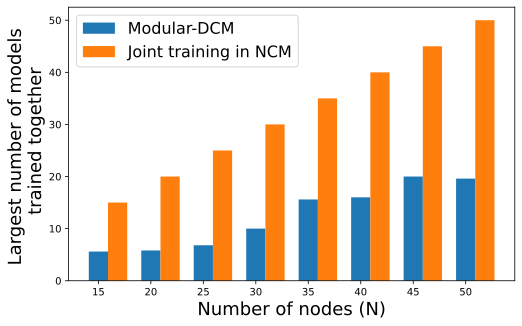

In [13]:
import pickle
import pylab as plb

plt.figure(figsize=(8,5), facecolor='white')
# plt.figure(figsize=(8,5))
plt.subplots_adjust(bottom=0.12)



title= "number_of_nodes"
# number_of_nodes={
#     'xaxis':xaxis,
#     'mech':y1axis,
#     'data':y2axis
# }
# save_loc = f'./results/{title}.pkl'
# with open(save_loc, 'wb') as f:
#     pickle.dump(number_of_nodes, f)

save_loc = f'./results/{title}.pkl'
with open(save_loc, 'rb') as f:
    object_file = pickle.load(f)
xaxis = object_file['xaxis']
y1axis = object_file['y1axis']
y2axis = object_file['y2axis']


joint= [n for n in range(15, 51, 5)]
barWidth = 1.83
br1 = xaxis
br2 = [x - barWidth for x in xaxis]
br3 = [x + barWidth for x in xaxis]
plt.bar(br1, y1axis, label='Modular-DCM', width=barWidth)
plt.bar(br3, joint, label='Joint training in NCM', width=barWidth)
plt.xticks(xaxis)
plt.xlabel('Number of nodes (N)', fontsize=18)
plt.ylabel('Largest number of models \n trained together', fontsize=18)
# plt.title('', fontsize=18)
plt.legend(fontsize=16)
plt.savefig('./plots/number_of_nodes.pdf')


In [58]:
arc_ratio={'xaxis': [5, 6, 8, 12, 16],
 'mech': [17.2, 15.6, 20.8, 21.4, 22.2],
 'data': [46.8, 46.6, 47.0, 48.2, 48.2]}
title= "arc_ratio"
save_loc = f'./results/{title}.pkl'
with open(save_loc, 'wb') as f:
    pickle.dump(arc_ratio, f)

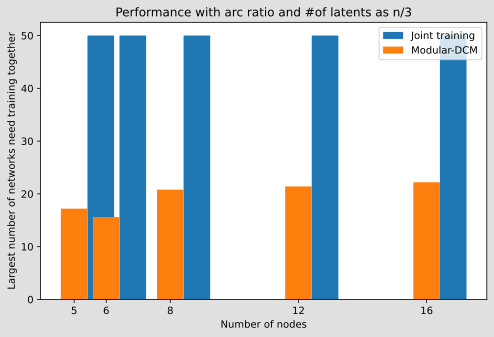

In [37]:
import pickle

xaxis=[int(n/10), int(n/8), int(n/6), int(n/4), int(n/3)]
joint= [n for i in range(len(xaxis))]


number_of_nodes={
    'xaxis':xaxis,
    'mech':y1axis,
    'data':y2axis
}


# save_loc = f'./results/{title}.pkl'
# with open(save_loc, 'rb') as f:
#     object_file = pickle.load(f)
# object_file

# joint= [n for n in range(15, 51, 5)]
plt.figure(figsize=(8,5))
barWidth = 0.83
br1 = xaxis
br2 = [x - barWidth for x in xaxis]
br3 = [x + barWidth for x in xaxis]
plt.bar(br3, joint, label='Joint training', width=barWidth)
plt.bar(br1, y1axis, label='Modular-DCM', width=barWidth)
plt.xticks(xaxis)
plt.xlabel('Number of nodes')
plt.ylabel('Largest number of networks need training together')
plt.title('Performance with arc ratio and #of latents as n/3')
plt.legend()

In [33]:
joint

[50, 50, 50, 50, 50]